In [1]:
import os
from scipy import stats
from process import *
from utils import *

/home/hongn/miniconda3/envs/xai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pre-defined

In [ ]:
TRIALS = {
    "all": TRIAL_LIST,
    "texture": TRIAL_TEXTURE,
    "complexity": TRIAL_COMPLEXITY,
    "orientation": TRIAL_ORIENTATION,
    "brightness": TRIAL_BRIGHTNESS,
    "contrast": TRIAL_CONTRAST,
    "color": TRIAL_COLOR,
    "depth": TRIAL_DEPTH,
    "face": TRIAL_FACE,
    "movement": TRIAL_MOVEMENT,
    "face_texture": TRIAL_FACE_TEXTURE,
}

these_trials = TRIALS["all"]
smap = "face"

def statistic_mw(x, y):
    return stats.mannwhitneyu(x, y)[0]


def iqr(x):
    q1, q3 = np.percentile(x, [25, 75])
    return q3 - q1


def extract_features(ids, trial, smap):
    if smap is not None:
        smap = trial.load_saliency_map(smap)
        smap_vs = trial.load_saliency_map("red")

    features = []
    for subject in ids:
        sub = Subject(DATA_ROOT, subject)
        out = sub.extract_fixations(trial_name=this_trial.trial_name)
        analyzer = FixationAnalyzer(DATA_ROOT, out)
        feat = analyzer.average_saliency(smap)
        feat_vs = analyzer.average_saliency(smap_vs)
        # feat = analyzer.number_of_fixations()
        # feat = sub.eye_mov_entropy(trial.trial_name, perplexity=True)
        features.append(feat - feat_vs)
        feats[subject].append(feat - feat_vs)
    return features

In [ ]:
class ImageTrial:
    def __init__(self, root, trial_name, smap_dir):
        self.root = root
        self.new_res = True if "new_res" in root else False
        self.path = glob.glob(f"/home/hong/cvi-stimuli/*{trial_name}*")[0]
        self.trial_name = trial_name
        self.smap_dir = smap_dir
        self.ids = glob.glob(os.path.join(root, "*.asc"))
        self.ids = [os.path.basename(d)[:-4] for d in self.ids]

    def load_trial_img(self):
        img = cv2.imread(self.path)
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    def load_saliency_map(self, smap_type):
        image_name = self.trial_name.strip(".jpg")
        filename = f"{image_name}_{smap_type}.jpg"
        path = os.path.join(self.smap_dir, image_name, filename)

        if os.path.exists(path):
            smap = plt.imread(path)
        else:
            os.makedirs(os.path.join(self.smap_dir, image_name), exist_ok=True)
            sal = SaliencyMap(smap_type)
            smap = sal.get_smap(self.load_trial_img())
            cv2.imwrite(path, smap)

        if self.new_res:
            smap = np.pad(smap, ((240, 240), (320, 320)), 'constant')
        return smap.T

    def complexity(self):
        img = self.load_trial_img()
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        stats = measure.regionprops(img)
        areas = [l.area for l in stats]
        rp_tot = img.shape[0] * img.shape[1]
        return sum(areas > (rp_tot / 25000))

    def read_subjects(self, names, vel=False):
        data, frac = {}, {}
        for subject in names:
            sub = Subject(subject)
            trial_data, frac = sub.extract_data(self.trial_name, vel)
            data[subject] = trial_data
            frac[subject] = 1 - frac
        return data, frac

    def read_fixations(self, names):
        fixations = {}
        for subject in names:
            sub = Subject(subject)
            this = sub.extract_fixations(self.trial_name)
            fixations[subject] = this
        return fixations

    def extract_traces(self, names, smap):
        traces = {}
        for subject in names:
            sub = Subject(subject)
            this = sub.extract_trace(self.trial_name, smap)
            traces[subject] = this
        return traces

## Testing

In [4]:
# DATA_ROOT = "/mnt/c/Users/PCM/Dropbox/cvi-asc/"
DATA_ROOT = "/home/hong/cvi-asc/"

In [5]:
# Get IDs of controls and cvi from files
ids = [i for i in os.listdir(DATA_ROOT) if i.endswith(".asc")]
ctrl_ids = [i.split(".")[0] for i in ids if i.startswith("2")]
cvi_ids = [i.split(".")[0] for i in ids if i.startswith("1")]
print(f'number of control {len(ctrl_ids)} and cvi {len(cvi_ids)}')

number of control 10 and cvi 31


In [8]:
# feats = {name.split(".")[0]: [] for name in ids}
# trial = these_trials[2]
# this_trial = ImageTrial(DATA_ROOT, trial, "smaps")
# trial

In [9]:
# subject = cvi_ids[1]
# sub = Subject(DATA_ROOT, subject)
# out = sub.extract_fixations(trial_name='Freeviewingstillimage_2')
# out_saccade = sub.extract_saccades(trial_name=this_trial.trial_name)
# analyzer = FixationAnalyzer(DATA_ROOT, out)

In [11]:
# cvi_train = {}
# ctrl_train = {}
# for sbjname in ['1006_2']:
# # subject = cvi_ids[1]
#     sub = Subject(DATA_ROOT, sbjname)
#     trainctmc = []
#     for name in these_trials:  
#         temp = sub.get_CTMC(trial_name=name)
#         if(len(temp) > 2):
#             trainctmc.append(temp)
#     cvi_train[sbjname] = trainctmc

In [9]:
# clean data and put it in CTMC format
cvi_train = {}
ctrl_train = {}
for sbjname in cvi_ids:
# subject = cvi_ids[1]
    sub = Subject(DATA_ROOT, sbjname)
    trainctmc = []
    for name in these_trials:  
        temp = sub.get_CTMC(trial_name=name)
        if(len(temp) > 2):
            trainctmc.append(temp)
    cvi_train[sbjname] = trainctmc

for sbjname in ctrl_ids:
# subject = cvi_ids[1]
    sub = Subject(DATA_ROOT, sbjname)
    trainctmc = []
    for name in these_trials:  
        temp = sub.get_CTMC(trial_name=name)
        if(len(temp) > 2):
            trainctmc.append(temp)
    ctrl_train[sbjname] = trainctmc


## CTMC

In [10]:
import jajapy as ja
from jajapy.base.Set import Set

In [11]:
print('len of training ', len(cvi_train.keys()))
cvi_train.keys()

len of training  31


dict_keys(['1003_2', '1007_4', '1011_2', '1010_2', '1017_2', '1007_2', '1004_2', '1020_2', '1013_1', '1010_1', '1011_1', '1006_3', '1006_4', '1022_1', '1019_1', '1017_1', '1005_1', '1007_1', '1013_2', '1015_1', '1003_3', '1015_2', '1022_2', '1007_3', '1003_4', '1006_2', '1008_1', '1006_1', '1018_1', '1020_1', '1018_2'])

In [20]:
# Delete keys that have zeros length
del_keys = []
for key in cvi_train:
    if(len(cvi_train[key]) < 2):
        del_keys.append(key)
for key in del_keys:
    del cvi_train[key]
del cvi_train['1013_2']

In [13]:
# convert dict to one array
# cvi_train_all = []
# ctrl_train_all = []

# for key in cvi_train:
#     cvi_train_all += cvi_train[key]

# for key in ctrl_train:
#     ctrl_train_all += ctrl_train[key]

In [21]:
# Save training
import pickle 

# with open('ctrl_train_all.pkl', 'wb') as f:
#     pickle.dump(ctrl_train_all, f)
with open('ctrl_train.pkl', 'wb') as f:
    pickle.dump(ctrl_train, f)
# with open('cvi_train_all.pkl', 'wb') as f:
#     pickle.dump(cvi_train_all, f)
with open('cvi_train.pkl', 'wb') as f:
    pickle.dump(cvi_train, f)

In [25]:
nb_trials = 5
ctmc_ctrl_models = {}
ctmc_cvi_models = {}

for key in cvi_train:
    print(key)
    best_model = None
    quality_best = -1024
    for n in range(1,nb_trials+1):
        current_model = ja.CTMC_random(nb_states=3,
                                labelling=['EFIX','ESACC','EBLINK'],
                                self_loop=False,
                                random_initial_state=True,
                                min_exit_rate_time=1,
                                max_exit_rate_time=6)
        current_quality = current_model.logLikelihood(Set(cvi_train[key], [1] * len(cvi_train[key]), t=4))
        if quality_best < current_quality: #we keep the best model only
                        quality_best = current_quality
                        best_model = current_model

    ctmc_cvi_models[key] = ja.BW().fit(Set(cvi_train[key], [1] * len(cvi_train[key]), t=4),initial_model=best_model,  stormpy_output=False)

for key in ctrl_train:
    print(key)
    best_model = None
    quality_best = -1024
    for n in range(1,nb_trials+1):
        current_model = ja.CTMC_random(nb_states=3,
                                labelling=['EFIX','ESACC','EBLINK'],
                                self_loop=False,
                                random_initial_state=True,
                                min_exit_rate_time=1,
                                max_exit_rate_time=6)
        current_quality = current_model.logLikelihood(Set(ctrl_train[key], [1] * len(ctrl_train[key]), t=4))
        if quality_best < current_quality: #we keep the best model only
                        quality_best = current_quality
                        best_model = current_model

    ctmc_ctrl_models[key] = ja.BW().fit(Set(ctrl_train[key], [1] * len(ctrl_train[key]), t=4),initial_model=best_model,  stormpy_output=False)

1003_2


Learning a CTMC...
|████████████████████████████████████████| 4 in 0.4s (9.92/s) 
1007_4
Learning a CTMC...
|████████████████████████████████████████| 4 in 0.4s (9.29/s) 
1010_2
Learning a CTMC...
|████████████████████████████████████████| 4 in 0.4s (9.29/s) 
1007_2
Learning a CTMC...
|████████████████████████████████████████| 4 in 0.5s (8.64/s) 
1020_2
Learning a CTMC...
|████████████████████████████████████████| 4 in 0.5s (8.70/s) 
1011_1
Learning a CTMC...
|████████████████████████████████████████| 4 in 0.4s (9.05/s) 
1006_3
Learning a CTMC...
|████████████████████████████████████████| 4 in 0.4s (10.10/s) 
1006_4
Learning a CTMC...
|████████████████████████████████████████| 4 in 0.4s (9.01/s) 
1017_1
Learning a CTMC...
|████████████████████████████████████████| 4 in 0.4s (9.64/s) 
1005_1
Learning a CTMC...
|████████████████████████████████████████| 4 in 0.4s (10.00/s) 
1007_1
Learning a CTMC...
|████████████████████████████████████████| 4 in 0.4s (10.33/s) 
1015_1
Learning a CTMC...

In [29]:
import pickle 

with open('ctmc_cvi_models.pkl', 'wb') as f:
    pickle.dump(ctmc_cvi_models, f)
with open('ctmc_ctrl_models.pkl', 'wb') as f:
    pickle.dump(ctmc_ctrl_models, f)

In [27]:
ctmc_cvi_models['1006_4'].matrix

array([[0.        , 0.00484362, 0.00110711, 0.        ],
       [0.0050925 , 0.        , 0.        , 0.        ],
       [0.000625  , 0.013125  , 0.        , 0.        ],
       [0.00057854, 0.        , 0.00108476, 0.        ]], dtype=float128)

## Z-Test

In [7]:
import pickle 
with open('ctmc_ctrl_models.pkl', 'rb') as f:
    ctmc_ctrl_models = pickle.load(f)

with open('ctmc_cvi_models.pkl', 'rb') as f:
    ctmc_cvi_models = pickle.load(f)

In [2]:
ctmc_ctrl_models.keys()

dict_keys(['2015_1', '2018_1', '2019_1', '2038_1', '2014_1', '2045_1', '2024_1', '2037_1', '2025_1', '2039_1', '2023_1', '2011_1', '2013_1', '2026_1', '2009_1', '2040_1', '2044_1', '2017_1', '2010_1', '2036_1', '2022_1', '2043_1', '2008_1', '2031_1'])

In [3]:
import numpy as np

hypoexp_ctrl = 0
for key in ctmc_ctrl_models:
    hypoexp_ctrl += np.reciprocal(ctmc_ctrl_models[key].matrix)

hypoexp_ctrl = hypoexp_ctrl/len(ctmc_ctrl_models)
hypoexp_ctrl

/tmp/ipykernel_27502/3365741505.py:5: RuntimeWarning: divide by zero encountered in reciprocal
  hypoexp_ctrl += np.reciprocal(ctmc_ctrl_models[key].matrix)


array([[         inf,  54.74354532, 789.33295829,          inf],
       [299.75664415,          inf,          inf,          inf],
       [         inf,  55.71172928,          inf,          inf],
       [477.24943023,          inf,          inf,          inf]],
      dtype=float128)

In [4]:
hypoexp_ctrl[0][1]

54.743545318838118124

In [5]:
type(ctmc_ctrl_models[key].matrix[0][1].astype(np.float64))

numpy.float64

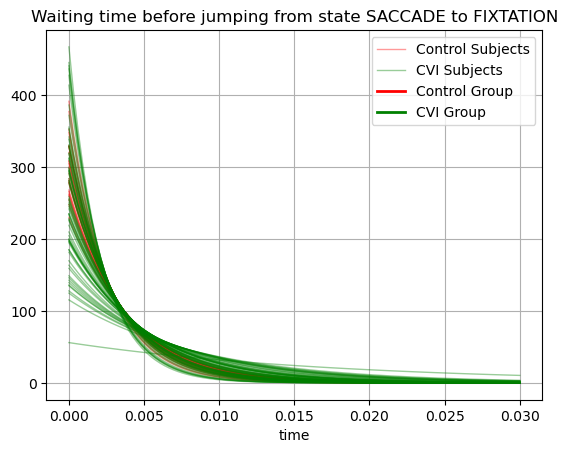

In [8]:
import numpy as np
from scipy.stats import expon
import matplotlib.pyplot as plt
x = np.linspace(0, 0.03, num=100)
fig, ax = plt.subplots(1, 1)
i = 1
j = 0
for key in ctmc_ctrl_models:
    ctrlsbj = ax.plot(x, expon(scale=ctmc_ctrl_models[key].matrix[i][j].astype(np.float64)).pdf(x),'r-', lw=1, alpha=0.4)

for key in ctmc_cvi_models:
    ax.plot(x, expon(scale=ctmc_cvi_models[key].matrix[i][j].astype(np.float64)).pdf(x),'g-', lw=1, alpha=0.4)

# plt.plot(x, expon(scale=ctmc_ctrl_model.matrix[i][j].astype(np.float64)).pdf(x),'r-', lw=2, alpha=1)
# plt.plot(x, expon(scale=ctmc_cvi_model.matrix[i][j].astype(np.float64)).pdf(x),'g-', lw=2, alpha=1)
plt.grid()
from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], color='red', lw=1, alpha=0.4),
            Line2D([0], [0], color='green', lw=1, alpha=0.4),
            Line2D([0], [0], color='red', lw=2, alpha=1),
            Line2D([0], [0], color='green', lw=2, alpha=1)]

plt.legend(custom_lines, ['Control Subjects', 'CVI Subjects','Control Group', 'CVI Group'])
plt.title('Waiting time before jumping from state SACCADE to FIXTATION')
plt.xlabel('time')
plt.show()

## Stationary Distribution

In [9]:
ctmc_ctrl_models.keys()

dict_keys(['2015_1', '2018_1', '2019_1', '2038_1', '2014_1', '2045_1', '2024_1', '2037_1', '2025_1', '2039_1', '2023_1', '2011_1', '2013_1', '2026_1', '2009_1', '2040_1', '2044_1', '2017_1', '2010_1', '2036_1', '2022_1', '2043_1', '2008_1', '2031_1'])

In [10]:
ctmc_ctrl_models['2005_1'].matrix

KeyError: '2005_1'

In [11]:
np.linalg.det(ctmc_ctrl_models['2005_1'].matrix.astype(np.float64))

KeyError: '2005_1'

In [12]:
def get_rate_matrix(ctmc_model):
    matrix = ctmc_model.matrix.astype(np.float64)
    for i in range(len(matrix)):
        matrix[i][i] = np.sum(matrix[i])*(-1)
    return np.matrix.transpose(matrix)

def get_stationary_dis(ctmc_model):
    A = get_rate_matrix(ctmc_model)
    b = np.zeros((5,1))
    A = np.vstack((A,np.ones(4)))
    b[4] = 1
    lsq = np.linalg.lstsq(A, b, rcond=None)
    return lsq[0].flatten()

In [14]:
ctmc_ctrl_models.keys()

dict_keys(['2015_1', '2018_1', '2019_1', '2038_1', '2014_1', '2045_1', '2024_1', '2037_1', '2025_1', '2039_1', '2023_1', '2011_1', '2013_1', '2026_1', '2009_1', '2040_1', '2044_1', '2017_1', '2010_1', '2036_1', '2022_1', '2043_1', '2008_1', '2031_1'])

In [15]:
get_stationary_dis(ctmc_ctrl_models['2015_1'])

array([1.50517846e-01, 8.43071610e-01, 6.41054423e-03, 1.47332169e-15])

In [22]:
np.mean(np.row_stack(ctrl_temp), 0)

array([ 1.40467996e-01,  8.46701772e-01,  1.28302318e-02, -7.74659641e-16])

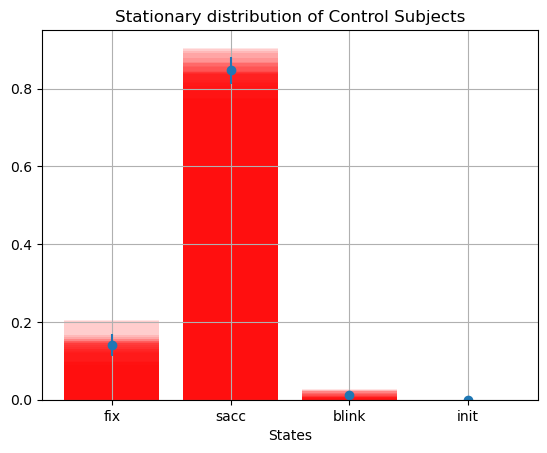

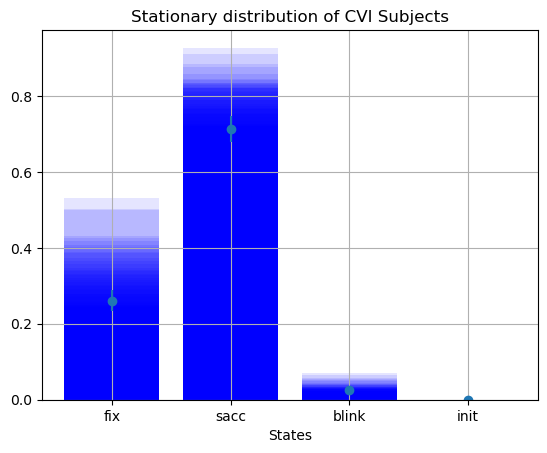

In [26]:
# plt.bar(['fix', 'sacc', 'blink', 'init'], lsq[0].flatten())
fig, ax = plt.subplots(1, 1)
ctrl_temp = []
cvi_temp = []

for key in ctmc_ctrl_models:
    ctrl_temp.append(get_stationary_dis(ctmc_ctrl_models[key]))
    ax.bar(['fix', 'sacc', 'blink', 'init'], get_stationary_dis(ctmc_ctrl_models[key]), color= 'red', alpha=0.1)
ax.errorbar(['fix', 'sacc', 'blink', 'init'], np.mean(np.row_stack(ctrl_temp), 0),
             yerr = np.std(np.row_stack(ctrl_temp), 0),
             fmt ='o')
plt.title('Stationary distribution of Control Subjects')
plt.xlabel('States')
plt.grid()
plt.show()
for key in ctmc_cvi_models:
    cvi_temp.append(get_stationary_dis(ctmc_cvi_models[key]))
    plt.bar(['fix', 'sacc', 'blink', 'init'], get_stationary_dis(ctmc_cvi_models[key]), color= 'blue', alpha=0.1)
plt.errorbar(['fix', 'sacc', 'blink', 'init'], np.mean(np.row_stack(cvi_temp), 0),
             yerr = np.std(np.row_stack(ctrl_temp), 0),
             fmt ='o')
plt.title('Stationary distribution of CVI Subjects')
plt.xlabel('States')
plt.grid()
plt.show()

Text(0.5, 0, 'States')

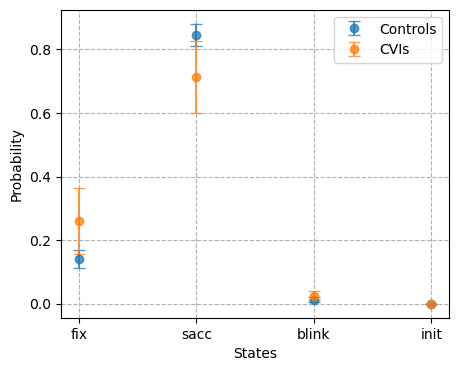

In [53]:
import matplotlib.pyplot as pyplt

pyplt.rcParams["figure.figsize"] = (5, 4)
plt.errorbar(['fix', 'sacc', 'blink', 'init'], np.mean(np.row_stack(ctrl_temp), 0),
             yerr = np.std(np.row_stack(ctrl_temp), 0),
             fmt ='o', alpha=.75, capsize=4, capthick=1)
plt.errorbar(['fix', 'sacc', 'blink', 'init'], np.mean(np.row_stack(cvi_temp), 0),
             yerr = np.std(np.row_stack(cvi_temp), 0),
             fmt ='o', alpha=.75, capsize=4, capthick=1)
plt.grid(linestyle='--')
plt.legend(['Controls', 'CVIs'])
plt.ylabel('Probability')
plt.xlabel('States')

<BarContainer object of 4 artists>

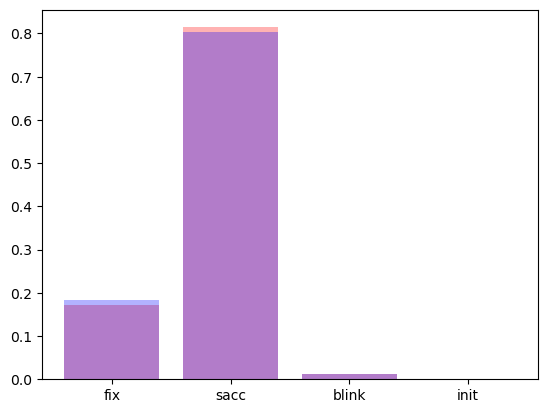

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.bar(['fix', 'sacc', 'blink', 'init'], get_stationary_dis(ctmc_ctrl_model), color= 'red', alpha=0.3)
ax.bar(['fix', 'sacc', 'blink', 'init'], get_stationary_dis(ctmc_cvi_model), color= 'blue', alpha=0.3)

In [ ]:
with open('ctmc_ctrl_model.pkl', 'wb') as f:
    pickle.dump(ctmc_ctrl_model, f)
with open('ctmc_cvi_model.pkl', 'wb') as f:
    pickle.dump(ctmc_cvi_model, f)

## Setting 1

In [ ]:
cvi_train_all


[['init',
  468.0,
  'EFIX',
  48.0,
  'ESACC',
  84.0,
  'EFIX',
  16.0,
  'ESACC',
  330.0,
  'EFIX',
  30.0,
  'ESACC',
  250.0,
  'EFIX',
  16.0,
  'ESACC',
  758.0,
  'EFIX',
  42.0,
  'ESACC'],
 ['init',
  526.0,
  'EFIX',
  60.0,
  'ESACC',
  514.0,
  'EFIX',
  26.0,
  'ESACC',
  796.0,
  'EFIX',
  166.0,
  'EBLINK'],
 ['init',
  184.0,
  'EBLINK',
  42.0,
  'ESACC',
  144.0,
  'EFIX',
  44.0,
  'ESACC',
  152.0,
  'EFIX',
  84.0,
  'EBLINK',
  48.0,
  'ESACC',
  516.0,
  'EFIX',
  26.0,
  'ESACC',
  262.0,
  'EFIX',
  24.0,
  'ESACC',
  158.0,
  'EFIX'],
 ['init',
  852.0,
  'EFIX',
  62.0,
  'ESACC',
  468.0,
  'EFIX',
  26.0,
  'ESACC',
  400.0,
  'EFIX',
  48.0,
  'ESACC'],
 ['init',
  80.0,
  'EFIX',
  34.0,
  'ESACC',
  142.0,
  'EFIX',
  14.0,
  'ESACC',
  106.0,
  'EFIX',
  18.0,
  'ESACC',
  114.0,
  'EFIX',
  64.0,
  'ESACC',
  516.0,
  'EFIX',
  22.0,
  'ESACC',
  398.0,
  'EFIX',
  24.0,
  'ESACC'],
 ['init', 1654.0, 'EBLINK', 72.0, 'ESACC', 238.0, 'EFIX', 20.0, 'ESA

In [ ]:
nb_trials = 5
best_model = None
quality_best = -1024
for n in range(1,nb_trials+1):
    current_model = ja.CTMC_random(nb_states=3,
                            labelling=['EFIX','ESACC','EBLINK'],
                            self_loop=False,
                            random_initial_state=False,
                            min_exit_rate_time=1,
                            max_exit_rate_time=6)
    current_quality = current_model.logLikelihood(Set(cvi_train_all, [1] * len(cvi_train_all), t=4))
    if quality_best < current_quality: #we keep the best model only
                    quality_best = current_quality
                    best_model = current_model
ctmc_cvi_model = ja.BW().fit(Set(cvi_train_all, [1] * len(cvi_train_all), t=4),initial_model=best_model)

Learning a CTMC...
|████████████████████████████████████████| 4 in 0.9s (4.43/s) 


In [ ]:
nb_trials = 5
best_model = None
quality_best = -1024
for n in range(1,nb_trials+1):
    current_model = ja.CTMC_random(nb_states=3,
                            labelling=['EFIX','ESACC','EBLINK'],
                            self_loop=False,
                            random_initial_state=False,
                            min_exit_rate_time=1,
                            max_exit_rate_time=6)
    current_quality = current_model.logLikelihood(Set(ctrl_train_all, [1] * len(ctrl_train_all), t=4))
    if quality_best < current_quality: #we keep the best model only
                    quality_best = current_quality
                    best_model = current_model
ctmc_ctrl_model = ja.BW().fit(Set(ctrl_train_all, [1] * len(ctrl_train_all), t=4),initial_model=best_model)

Learning a CTMC...
|████████████████████████████████████████| 4 in 1.0s (3.93/s) 


In [ ]:
print(ctmc_ctrl_model)

Name: CTMC_random_3_states
Initial state: s3
----STATE 0--EFIX----
Exepected waiting time: 53.29631864815932408
s0 -> s1 : lambda = 0.016487000634115409004
s0 -> s2 : lambda = 0.0022760213787480750067

----STATE 1--ESACC----
Exepected waiting time: 251.2681210415200563
s1 -> s0 : lambda = 0.003979812464290915609

----STATE 2--EBLINK----
Exepected waiting time: 32.857142857142857144
s2 -> s1 : lambda = 0.030434782608695652174

----STATE 3--init----
Exepected waiting time: 251.56115107913669066
s3 -> s0 : lambda = 0.003975176595075356765





In [ ]:
ctmc_cvi_model.matrix

array([[0.        , 0.01311654, 0.00115783, 0.        ],
       [0.00325286, 0.        , 0.        , 0.        ],
       [0.        , 0.01677516, 0.        , 0.        ],
       [0.00288009, 0.        , 0.        , 0.        ]], dtype=float128)

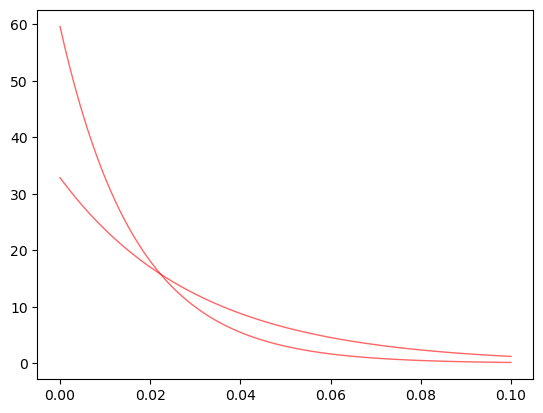

In [ ]:
x = np.linspace(0, 0.1, num=100)
plt.plot(x, expon(scale=ctmc_ctrl_model.matrix[i][j].astype(np.float64)).pdf(x),'r-', lw=1, alpha=0.6)
plt.plot(x, expon(scale=ctmc_cvi_model.matrix[i][j].astype(np.float64)).pdf(x),'r-', lw=1, alpha=0.6)

(array([453., 229., 141.,  69.,  45.,  25.,  19.,  10.,   5.,   4.]),
 array([9.10817865e-06, 1.78237623e-02, 3.56384164e-02, 5.34530705e-02,
        7.12677246e-02, 8.90823787e-02, 1.06897033e-01, 1.24711687e-01,
        1.42526341e-01, 1.60340995e-01, 1.78155649e-01]),
 <BarContainer object of 10 artists>)

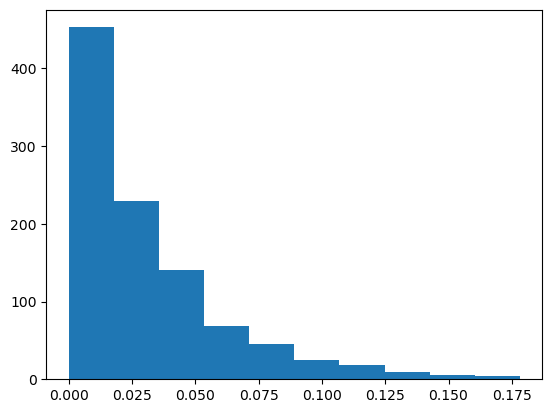

In [ ]:
plt.hist(expon(scale=ctmc_ctrl_model.matrix[i][j].astype(np.float64)).rvs(1000))

In [ ]:
ctmc_ctrl_model.matrix[0][1].astype(np.float64)

0.016487000634115408

In [ ]:
ctmc_cvi_model.matrix[0][1].astype(np.float64)

0.013116543716298919

In [ ]:
from scipy.stats import kstest

stat, p_value = kstest(expon(scale=ctmc_ctrl_model.matrix[0][1].astype(np.float64)).rvs(10000), expon(scale=0.0131).rvs(100))
print(f" Kolmogorov-Smirnov Test: statistic={stat:.4f}, p-value={p_value:.4f}")

 Kolmogorov-Smirnov Test: statistic=0.0631, p-value=0.8023
